In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as impg

%matplotlib inline

In [2]:
def calibrate_camera(images, nx = 9, ny = 6):
    '''
    Find require parameters to calibrate camera with chessboard images
    param: 
        images: recommending at least 20 images
        nx: number of corners each row
        ny: number of corners each column
    return:
        mtx: camera matrix
        dist: distortion coeficients
    '''
    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    objpoints = []
    imgpoints = []
    for img_path in camera_cal_img_paths:
        img = plt.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            #plt.imshow(img)
            objpoints.append(objp)
            imgpoints.append(corners)
            
    # camera calibration
    ret, mtx, dist, rvess, tvess = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return (mtx, dist)


def threshold_sx_s(image, sx_thres = [20, 100], s_thres = [120, 255]):
    '''
    Saturation and gradient of lightness on x direction thresholding the image and generate a binary image
    param:
        image: a image, require color space is RGB
        sx_thres: a list, [lower_bound, higher_bound] threshold for scaled sobel x
        s_thres: a list, [lower_bound, higher_bound] threshold for saturation channel
    return:
        a binary image after applying both thresholding 
    '''
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    sxbinary = np.zeros_like(l_channel)
    sxbinary[(scaled_sobel >= sx_thres[0]) & (scaled_sobel < sx_thres[1])] = 1
    
    s_binary = np.zeros_like(l_channel)
    s_binary[(s_channel >= s_thres[0]) & (s_channel < s_thres[1])] = 1
    
    combined_binary = np.zeros_like(l_channel)
    combined_binary[(sxbinary == 1) | (s_binary == 1)] = 1
    
    return combined_binary


def perspective_transform(src, dest):
    '''
    Find both transform matrix and inverse transform matrix with provided srt and dest
    '''
    M = cv2.getPerspectiveTransform(src, dest)
    M_inv = cv2.getPerspectiveTransform(dest, src)
    return (M, M_inv)

In [3]:
def findLanes(binary_warped, nwindows = 9, margin = 75, minpix = 100):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return (left_fit, right_fit, leftx, lefty, rightx, righty)

In [4]:
def projectLane(image, left_fit, right_fit, M_inv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

In [5]:
def add_curvature(new_image, y_eval, num_pix_x, leftx, lefty, rightx, righty, ym_per_pix = 30/720, xm_per_pix = 3.7/800):
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    lane_center = (right_fit_cr[2] - left_fit_cr[2]) / 2 + left_fit_cr[2] 
    vehicle_center = (num_pix_x * xm_per_pix) / 2
    to_left = lane_center - vehicle_center
    text1 = 'Left curverad: {0:.0f}(m), Right curverad: {1:.0f}(m)'.format(
    left_curverad, right_curverad)
    text2 = 'Vehicle is {:.3f} m left to the center'.format(to_left)
    result = new_image.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, text1, (100,100), font, 1, (255,255,255),2, cv2.LINE_AA)
    cv2.putText(result, text2, (100,150), font, 1,(255,255,255), 2, cv2.LINE_AA)
    
    return result

In [31]:
def process_image(image):
    global count
    count += 1
    undist = cv2.undistort(image,
                           mtx,
                           dst,
                           None, 
                           mtx)
    binary_warped = threshold_sx_s(undist)
    warped = cv2.warpPerspective(binary_warped, 
                                 M, 
                                 binary_warped.shape[::-1], 
                                 flags = cv2.INTER_LINEAR)
    left_fit, right_fit, leftx, lefty, rightx, righty = findLanes(warped)

    new_image= projectLane(undist,
                           left_fit,
                           right_fit, 
                           M_inv)
    
    new_image = add_curvature(new_image,
                             new_image.shape[0],
                             new_image.shape[1],
                             leftx,
                             lefty,
                             rightx,
                             righty)
    return new_image

In [22]:
camera_cal_img_paths = list(map(lambda path: './camera_cal/' + path.split('\\')[-1] ,
                     glob.glob('./camera_cal/*.jpg')))
camera_cal_imgs = [plt.imread(img_path) for img_path in camera_cal_img_paths]


In [23]:
test_img_paths = list(map(lambda path: './test_images/' + path.split('\\')[-1],
                          glob.glob('./test_images/*.jpg')))
test_imgs = [plt.imread(img_path) for img_path in test_img_paths]

In [24]:
mtx, dst = calibrate_camera(camera_cal_imgs, 9, 6)

In [25]:
src = np.float32([[570, 467],
                  [206, 720], 
                  [715, 467],
                  [1100, 720]])
dest = np.float32([[325, 200],
                   [325, 720],
                   [968, 200],
                   [968, 720]])

M, M_inv = perspective_transform(src, dest)

In [38]:
count = 0

2


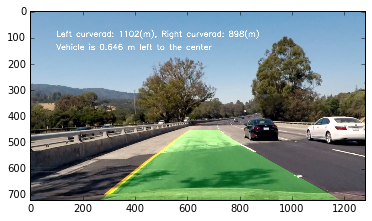

In [33]:
new_image= process_image(test_imgs[5])
plt.imshow(new_image)
print(count)

In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
clip1 = VideoFileClip("./project_video.mp4")

In [39]:
out_clip = clip1.fl_image(process_image)

In [42]:
count 

1261

In [41]:
output = './out_clip.mp4'
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./out_clip.mp4
[MoviePy] Writing video ./out_clip.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:48<00:00, 11.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./out_clip.mp4 

Wall time: 1min 49s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))